# Importing Packages

In [1]:
# %pip install 'tensorflow[and-cuda]'
# %pip install transformers
# %pip install tf-keras
# %pip install tensorflow-hub

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Lambda
import cv2
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import seaborn as sns
import numpy as np
from PIL import Image
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [3]:
!nvidia-smi

Sat Feb  1 13:12:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8419387707544999392
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18221813199152062206
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9751809861974605921
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data Ingestion

In [7]:
# !unzip ./final_dataset_2.zip -d ./final_dataset_2
# !unzip ./val_images.zip -d ./val_images

In [184]:
df = pd.read_csv('/kaggle/input/final-memes-dataset-cleaned/final_dataset.csv')
df.head()

,image_path,label,meme_text,file_extension,language_code,sentence_length,average_word_length,hashtags_count,emails_count,numbers_count,usernames_count,websites,pos_tags,named_entities,new_image_path,meme_text_masked
0,./dataset/violence against women meme offensiv...,1,When mom takes away my fidget spinner.,jpg,Language.ENGLISH,7,4.571429,0,0,0,0,[],"['SCONJ', 'NOUN', 'VERB', 'ADV', 'PRON', 'NOUN...",[],final_dataset/Image_15_0d42f67a-74dd-4415-b286...,When mom takes away my fidget spinner.
1,./dataset/violence against women meme offensiv...,1,Morning wood? You mean my wife's alarm clock.,jpg,Language.ENGLISH,8,4.750000,0,0,0,0,[],"['NOUN', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'PRO...",[],final_dataset/Image_14_255b3022-61df-4e4e-93d0...,Morning wood? You mean my wife's alarm clock.
2,./dataset/violence against women meme offensiv...,1,When captain man calls you to the man cave at ...,jpg,Language.ENGLISH,23,3.956522,0,0,0,0,[],"['SCONJ', 'NOUN', 'NOUN', 'VERB', 'PRON', 'ADP...",['TIME'],final_dataset/Image_16_fa940fca-ef00-4425-851e...,When captain man calls you to the man cave at ...
3,./dataset/violence against women meme offensiv...,1,KILL ALL JEWISHS.,jpg,Language.ENGLISH,3,5.000000,0,0,0,0,[],"['VERB', 'DET', 'PROPN', 'PUNCT']",['ORG'],final_dataset/Image_17_bb0e97ae-e051-4482-a394...,KILL ALL JEWISHS.
4,./dataset/violence against women meme offensiv...,1,The violence has escalated.,png,Language.ENGLISH,4,6.000000,0,0,0,0,[],"['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']",[],final_dataset/Image_13_b5413513-2d35-4269-bf4f...,The violence has escalated.


3it [00:00, 94.53it/s]


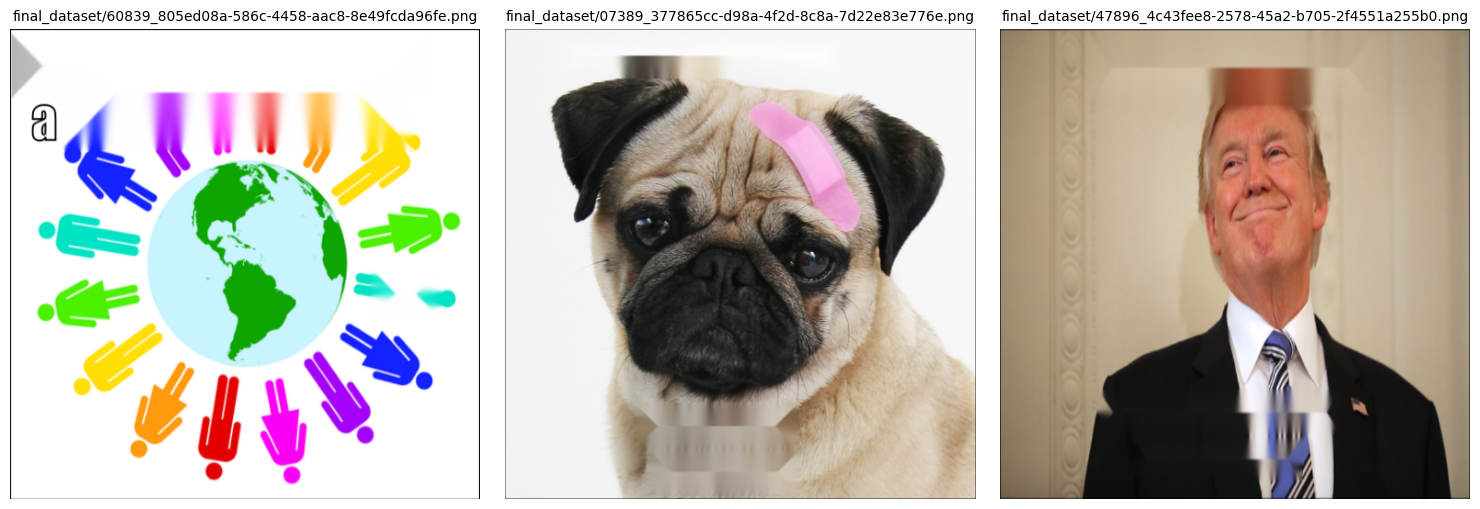

In [185]:
def display_random_images(df, image_column):
    sampled_rows = df.sample(n=3)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, (_, row) in tqdm(zip(axes, sampled_rows.iterrows())):
        try:
            image_path = row[image_column].replace("final_dataset/", "/kaggle/input/final-memes-dataset-cleaned/final_dataset 2/final_dataset/")
            image_path = f"{image_path}"
            
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')  # Turn off axis
            
            ax.set_title(row[image_column], fontsize=10)
        except Exception as e:
            ax.set_title("Error loading image", fontsize=10)
            ax.axis('off')
            print(f"Error loading image: {e}")
    
    plt.tight_layout()
    plt.show()

display_random_images(df, "new_image_path")

In [186]:
df['new_image_path'] = df['new_image_path'].str.replace("final_dataset/", "/kaggle/input/final-memes-dataset-cleaned/final_dataset 2/final_dataset/")
df['new_image_path'].head()

0    /kaggle/input/final-memes-dataset-cleaned/fina...
1    /kaggle/input/final-memes-dataset-cleaned/fina...
2    /kaggle/input/final-memes-dataset-cleaned/fina...
3    /kaggle/input/final-memes-dataset-cleaned/fina...
4    /kaggle/input/final-memes-dataset-cleaned/fina...
Name: new_image_path, dtype: object

<div class="alert alert-info" role="alert">
Since the processing was done on kaggle notebooks (due to GPU limitations on google colab), the file paths needed to be updated accordingly
</div>

# Modelling

In [187]:
train_df = df[["new_image_path", "meme_text_masked", "label"]]
train_df.head()

,new_image_path,meme_text_masked,label
0,/kaggle/input/final-memes-dataset-cleaned/fina...,When mom takes away my fidget spinner.,1
1,/kaggle/input/final-memes-dataset-cleaned/fina...,Morning wood? You mean my wife's alarm clock.,1
2,/kaggle/input/final-memes-dataset-cleaned/fina...,When captain man calls you to the man cave at ...,1
3,/kaggle/input/final-memes-dataset-cleaned/fina...,KILL ALL JEWISHS.,1
4,/kaggle/input/final-memes-dataset-cleaned/fina...,The violence has escalated.,1


In [188]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print("Training set:")
print("Training shape:", train_df.shape)
display(train_df.head())

print("Validation set:")
print("Validation shape:", val_df.shape)
display(val_df.head())

Training set:
Training shape: (8779, 3)


,new_image_path,meme_text_masked,label
9523,/kaggle/input/final-memes-dataset-cleaned/fina...,when all your peaceful solutions fails you kno...,0
5839,/kaggle/input/final-memes-dataset-cleaned/fina...,mother fixing her daughters hair,0
6323,/kaggle/input/final-memes-dataset-cleaned/fina...,tfw you hear that you should be able to walk a...,0
135,/kaggle/input/final-memes-dataset-cleaned/fina...,"Creeps into your child's room, empties his sack.",1
4830,/kaggle/input/final-memes-dataset-cleaned/fina...,that makes me moister than an oyster,0


Validation set:
Validation shape: (976, 3)


,new_image_path,meme_text_masked,label
4537,/kaggle/input/final-memes-dataset-cleaned/fina...,when you've been released from fb jail knowing...,0
4694,/kaggle/input/final-memes-dataset-cleaned/fina...,when you've accepted your sexual preferences a...,0
1606,/kaggle/input/final-memes-dataset-cleaned/fina...,when i was a boy we didn't have things like ad...,1
9572,/kaggle/input/final-memes-dataset-cleaned/fina...,what are they fighting over? is it: a) the las...,0
3540,/kaggle/input/final-memes-dataset-cleaned/fina...,if you got your phone wet try leaving it in dr...,0


<div class="alert alert-info" role="alert">
The train set will be used to train the models and the validation set will be used to verify the performance and tune the models further. This way, data leakage is prevented.
</div>

## Pure Text Classification Approach

### BERT model (frozen)

- A BERT model that has been trained on a large corpus (like Wikipedia) to understand language patterns. 
- "Freezing" means disabling weight updates during training. The model uses its pre-trained knowledge without learning from new data.
- This means no backpropogation through BERT layers and it acts as a fixed feature extractor, and only the classification head (output layer) learns.

In [189]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
inputs = tokenizer(train_df['meme_text_masked'].tolist(), padding=True, truncation=True, return_tensors="tf", max_length=128)

# Extract the input_ids, attention_mask from the tokenized inputs
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [191]:
X_train, X_val, y_train, y_val = train_test_split(input_ids.numpy(), train_df['label'], test_size=0.2, random_state=42)
train_attention_mask, val_attention_mask = train_test_split(attention_mask.numpy(), test_size=0.2, random_state=42)

In [212]:
# Load the pre-trained BERT model with a classification head
model_frozen = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Freeze all layers of the BERT model
for layer in model_frozen.layers:
    layer.trainable = False

# Build the model
model_frozen.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Train the frozen model
history_frozen = model_frozen.fit(
    {'input_ids': X_train, 'attention_mask': train_attention_mask}, 
    y_train, 
    validation_data=({'input_ids': X_val, 'attention_mask': val_attention_mask}, y_val),
    epochs=10, 
    batch_size=32
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
220/220 [==============================] - 105s 422ms/step - loss: 4.0621 - accuracy: 0.5438 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 2/10
220/220 [==============================] - 89s 406ms/step - loss: 4.0804 - accuracy: 0.5439 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 3/10
220/220 [==============================] - 89s 404ms/step - loss: 4.0619 - accuracy: 0.5421 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 4/10
220/220 [==============================] - 89s 404ms/step - loss: 4.0302 - accuracy: 0.5409 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 5/10
220/220 [==============================] - 89s 405ms/step - loss: 4.1027 - accuracy: 0.5398 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 6/10
220/220 [==============================] - 89s 405ms/step - loss: 4.1183 - accuracy: 0.5415 - val_loss: 4.7771 - val_accuracy: 0.5490
Epoch 7/10
220/220 [==============================] - 89s 405ms/step - loss: 4.0883 - accuracy: 0.5441 - val_loss: 4.7771 - val_a

<div class="alert alert-info" role="alert">
Trains the classification head using the frozen BERT embeddings. Runs for 3 epochs with a batch size of 32.
</div>

### BERT model (unfrozen)

- In this approach, all BERT layers are trainable, meaning their weights will be updated based on the new data during training.
- The model adapts BERT’s knowledge to the specific task (e.g., meme classification based on text only).
- Fine-tuning usually results in higher accuracy because BERT can adjust to domain-specific language patterns.
- However, it is often slower and more computationally expensive.

In [213]:
# Load the pre-trained BERT model with a classification head
model_unfrozen = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Allow fine-tuning (make all layers trainable)
for layer in model_unfrozen.layers:
    layer.trainable = True

# Compile the model
model_unfrozen.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the unfrozen model with EarlyStopping
history_unfrozen = model_unfrozen.fit(
    {'input_ids': X_train, 'attention_mask': train_attention_mask}, 
    y_train, 
    validation_data=({'input_ids': X_val, 'attention_mask': val_attention_mask}, y_val),
    epochs=10,                 # Increased max epochs, EarlyStopping will stop early if needed
    batch_size=32
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
 31/220 [===>..........................] - ETA: 2:44 - loss: 0.9205 - accuracy: 0.5444

KeyboardInterrupt: 

<div class="alert alert-info" role="alert">
Trains the entire BERT model (including its pre-trained layers) on the new meme dataset for 10 epochs with a batch size of 32.
</div>

In [24]:
# Evaluate the frozen model
frozen_eval = model_frozen.evaluate({'input_ids': X_val, 'attention_mask': val_attention_mask}, y_val)

# Evaluate the unfrozen model
unfrozen_eval = model_unfrozen.evaluate({'input_ids': X_val, 'attention_mask': val_attention_mask}, y_val)

print(f'Frozen model evaluation: {frozen_eval}')
print(f'Unfrozen model evaluation: {unfrozen_eval}')

55/55 [==============================] - 16s 288ms/step - loss: 0.6931 - accuracy: 0.5490
Frozen model evaluation: [1.875576376914978, 0.4664009213447571]
Unfrozen model evaluation: [0.6931473016738892, 0.5489749312400818]


In [26]:
# Tokenize the validation set (same as we did for the training set)
val_inputs = tokenizer(val_df['meme_text_masked'].tolist(), padding=True, truncation=True, return_tensors="tf", max_length=128)

# Extract the input_ids and attention_mask
val_input_ids = val_inputs['input_ids']
val_attention_mask = val_inputs['attention_mask']

# Function to get predictions from a model
def get_predictions(model, input_ids, attention_mask):
    # Get raw predictions (logits)
    logits = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask}).logits
    # Convert logits to class labels (highest probability)
    predictions = np.argmax(logits, axis=-1)
    return predictions

# Get predictions for the frozen model
frozen_predictions = get_predictions(model_frozen, val_input_ids, val_attention_mask)

# Get predictions for the unfrozen model
unfrozen_predictions = get_predictions(model_unfrozen, val_input_ids, val_attention_mask)

# Get the true labels from val_df
true_labels = val_df['label']

# Generate classification report for the frozen model
frozen_classification_report = classification_report(true_labels, frozen_predictions)

# Generate classification report for the unfrozen model
unfrozen_classification_report = classification_report(true_labels, unfrozen_predictions)

# Print the classification reports
print("Frozen Model Classification Report:")
print(frozen_classification_report)

print("Unfrozen Model Classification Report:")
print(unfrozen_classification_report)

31/31 [==============================] - 10s 232ms/step
Frozen Model Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       533
           1       0.36      0.18      0.24       443

    accuracy                           0.48       976
   macro avg       0.44      0.46      0.42       976
weighted avg       0.44      0.48      0.44       976

Unfrozen Model Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       533
           1       0.00      0.00      0.00       443

    accuracy                           0.55       976
   macro avg       0.27      0.50      0.35       976
weighted avg       0.30      0.55      0.39       976



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div class="alert alert-info" role="alert">
- The unfrozen model is heavily biased towards predicting class 0 (precision = 0.55, recall = 1.00), while it completely fails to identify class 1 (precision and recall = 0.00). This could indicate class imbalance, or the model is overfitting to dominant class patterns during fine-tuning. <br><br>
- Despite fine-tuning, the unfrozen model shows worse overall performance for class 1 compared to the frozen model. This suggests the unfrozen model may have overfit to training data and lost generalization capabilities, particularly for the minority class.<br><br>
- The frozen model provides a more balanced performance across both classes (though still weak for class 1) and has a lower overall accuracy (48% vs. 55%). However, its ability to at least partially recognize both classes suggests it might be less overfit compared to the unfrozen model.
</div>

## Pure Image Classification Approach

### Resnet50 model (frozen vs unfrozen)

In [16]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [15]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 
    return img_array

train_images = np.vstack([load_and_preprocess_image(img_path) for img_path in train_df['new_image_path']])
train_labels = np.array(train_df['label'])

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [18]:
base_model_frozen = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_frozen.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_frozen.output)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_frozen = Model(inputs=base_model_frozen.input, outputs=output)

model_frozen.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, 
                               restore_best_weights=True)

history_frozen = model_frozen.fit(X_train, y_train,
                                  validation_data=(X_val, y_val),
                                  epochs=20,
                                  batch_size=32,
                                  callbacks=[early_stopping])

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 166ms/step - accuracy: 0.5838 - loss: 0.7027 - val_accuracy: 0.5991 - val_loss: 0.6661
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.6942 - loss: 0.5752 - val_accuracy: 0.6298 - val_loss: 0.6441
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7504 - loss: 0.5154 - val_accuracy: 0.6401 - val_loss: 0.6714
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.7739 - loss: 0.4700 - val_accuracy: 0.6241 - val_loss: 0.6649
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.8140 - loss: 0.4252 - val_accuracy: 0.6014 - val_loss: 0.6994
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.8376 - loss: 0.3912 - val_accuracy: 0.6162 - val_loss: 0.6829
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.8735 - loss: 0.3394 - val_accuracy: 0.6133 - val_loss: 0.7066


<div class="alert alert-info" role="alert">
    
- The model is loaded with imagenet weights and it excludes the top (classification) layer<br>
- All layers of the resnet are frozen which means that the weight will not be updated during training<br>
- A custom classification head is added to the resnet50: <br>
    - GlobalAveragePooling2D reduces the spatial dimensions.<br>
    - A Dense layer with 1024 neurons and ReLU activation adds learning capacity.<br>
    - The final Dense layer with 1 neuron and sigmoid activation outputs probabilities for binary classification.<br>
</div>

In [19]:
base_model_unfrozen = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Allow fine-tuning by setting all layers to be trainable
for layer in base_model_unfrozen.layers:
    layer.trainable = True

# Add a new classification head on top
x = GlobalAveragePooling2D()(base_model_unfrozen.output)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x) 

model_unfrozen = Model(inputs=base_model_unfrozen.input, outputs=output)

model_unfrozen.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

history_unfrozen = model_unfrozen.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 164s 483ms/step - accuracy: 0.6047 - loss: 0.6954 - val_accuracy: 0.6458 - val_loss: 0.6528
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - accuracy: 0.7747 - loss: 0.4692 - val_accuracy: 0.6338 - val_loss: 0.6817
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - accuracy: 0.8745 - loss: 0.3135 - val_accuracy: 0.6418 - val_loss: 0.7747
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 329ms/step - accuracy: 0.9161 - loss: 0.2148 - val_accuracy: 0.5962 - val_loss: 1.1160
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.9412 - loss: 0.1531 - val_accuracy: 0.5900 - val_loss: 1.2390


<div class="alert alert-info" role="alert">
    
- The model is loaded with imagenet weights and it excludes the top (classification) layer<br>
- All layers of the resnet are unfrozen which means that the weight will be updated during training<br>
- A custom classification head is added to the resnet50: <br>
    - GlobalAveragePooling2D reduces the spatial dimensions.<br>
    - A Dense layer with 1024 neurons and ReLU activation adds learning capacity.<br>
    - The final Dense layer with 1 neuron and sigmoid activation outputs probabilities for binary classification.<br>
</div>

In [22]:
val_images = np.vstack([load_and_preprocess_image(img_path) for img_path in val_df['new_image_path']])
val_labels = np.array(val_df['label'])

In [23]:
frozen_predictions = (model_frozen.predict(val_images) > 0.5).astype("int32")
unfrozen_predictions = (model_unfrozen.predict(val_images) > 0.5).astype("int32")

frozen_classification_report = classification_report(val_labels, frozen_predictions)
unfrozen_classification_report = classification_report(val_labels, unfrozen_predictions)

print("Frozen Model Classification Report:")
print(frozen_classification_report)

print("Unfrozen Model Classification Report:")
print(unfrozen_classification_report)

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step
Frozen Model Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       533
           1       0.65      0.43      0.52       443

    accuracy                           0.64       976
   macro avg       0.64      0.62      0.62       976
weighted avg       0.64      0.64      0.62       976

Unfrozen Model Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70       533
           1       0.64      0.47      0.54       443

    accuracy                           0.64       976
   macro avg       0.64      0.62      0.62       976
weighted avg       0.64      0.64      0.63       976



<div class="alert alert-info" role="alert">

- Both models show nearly identical performance with accuracy around 64%. The precision and recall for class 1 are slightly better in the frozen model, while the unfrozen model improves slightly in precision for class 0, but overall, there is no significant difference between the two models in terms of metrics.
- The unfrozen model, despite fine-tuning, has not shown a substantial improvement in performance compared to the frozen model. This suggests that fine-tuning may not always lead to better results
</div>

## Multimodal Approach

In [98]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = TFCLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [99]:
# df['meme_text_masked'] = df['meme_text_masked'].fillna("").astype(str)
# df['meme_text_masked'] = df['meme_text_masked'].replace("", "No text provided")

# df['new_image_path'] = df['new_image_path'].apply(lambda x: f"./{x}" if not x.startswith("./") else x)

### multimodal clip model

- frozen clip model used to generate embeddings
- neural network for classification

In [100]:
def get_clip_embeddings_with_adapters(image_paths, texts, batch_size=32, embedding_dim=1024, alpha=0.5):
    image_embeds = []
    text_embeds = []

    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing Batches"):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_texts = texts[i:i + batch_size]

        try:
            images = [Image.open(p).convert("RGB") for p in batch_image_paths]
        except Exception as e:
            print(f"Error loading images in batch {i // batch_size + 1}. Example image paths: {batch_image_paths}")
            print(f"Error: {e}")
            continue

        try:
            inputs = clip_processor(text=batch_texts, images=images, return_tensors="tf", padding=True)
            outputs = clip_model(**inputs)

            image_embeds.append(outputs.image_embeds.numpy())
            text_embeds.append(outputs.text_embeds.numpy())
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}. Example texts: {batch_texts}")
            print(f"Error: {e}")
            continue 

    # Concatenate all batches
    if image_embeds and text_embeds:
        image_embeds = np.concatenate(image_embeds, axis=0)
        text_embeds = np.concatenate(text_embeds, axis=0)
        
        return image_embeds, text_embeds

    else:
        print("No valid embeddings generated.")
        return np.array([]), np.array([])

# Call the updated function
image_embeds, text_embeds = get_clip_embeddings_with_adapters(
    train_df['new_image_path'].tolist(),
    train_df['meme_text_masked'].tolist(),
    embedding_dim=1024, 
    alpha=0.5
)

Processing Batches: 100%|██████████| 275/275 [05:34<00:00,  1.22s/it]


<div class="alert alert-info" role="alert">

- CLIP embeddings are generated from the pretrained model
- Embedding dimension size is set to 512
- The image and text embeddings will be fused together to generate a single embedding
- A neural network will be trained on these embeddings to predict 
</div>

In [101]:
labels = train_df['label'].values
num_classes = len(np.unique(labels))
num_classes

2

In [102]:
# modality fusion

fused_embeds = image_embeds * text_embeds 
fused_embeds

array([[-1.7030376e-04,  1.4482884e-03,  2.2426366e-05, ...,
        -9.4596799e-05, -2.2222010e-05,  1.6215938e-05],
       [ 2.6264755e-04, -5.9198565e-04, -1.3060954e-04, ...,
        -6.7509990e-04, -3.8374419e-05, -3.8807414e-04],
       [-1.3688227e-04, -1.4959906e-04,  2.4004049e-04, ...,
         8.1428129e-04, -5.2609666e-05,  4.0872847e-06],
       ...,
       [ 9.5545658e-04, -3.7339405e-04,  3.9083636e-05, ...,
         2.0486943e-05,  1.4677437e-05,  8.2550687e-04],
       [ 1.2634946e-04, -1.5693007e-05,  5.8781843e-05, ...,
        -1.3179141e-03, -3.6568363e-04, -8.7050823e-05],
       [ 5.4784767e-05, -2.6823096e-05,  3.9132210e-04, ...,
        -2.5519289e-04,  1.1337040e-05,  2.1687309e-05]], dtype=float32)

In [103]:
fused_embeds.shape

(8779, 512)

<div class="alert alert-info" role="alert">
Both embeddings (text and images) are fused together by vector multiplication
</div>

In [154]:
# Create a stratified split
fused_embeds_train, fused_embeds_val, labels_train, labels_val = train_test_split(
    fused_embeds, labels, 
    test_size=0.2,        # 20% for validation
    stratify=labels,      # Ensures equal label distribution
    random_state=42       # For reproducibility
)

<div class="alert alert-info" role="alert">
    
- Splitting the train_df into train and val again. 
- The neural network uses the validation data to learn the patterns as well. 
- The validation dataset which was split the first time will be used to select the best model.
- Finally the test dataset will be imported and the best model will be evaluated against it
</div>

In [155]:
def simple_nn(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    # First hidden layer
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Second hidden layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = simple_nn(input_dim, num_classes)
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classification_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,753 (292.00 KB)

 Trainable params: 74,369 (290.50 KB)

 Non-trainable params: 384 (1.50 KB)

<div class="alert alert-info" role="alert">
Made use of the tensorflow functional API instead of the sequential API as it provides more customizability and flexibility in terms of model creation
</div>

In [156]:
optimizer = Adam(learning_rate=0.001)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with early stopping
history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5886 - loss: 0.6762 - val_accuracy: 0.5421 - val_loss: 0.6874
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6980 - loss: 0.5775 - val_accuracy: 0.5421 - val_loss: 0.6819
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7508 - loss: 0.5245 - val_accuracy: 0.6304 - val_loss: 0.6334
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7913 - loss: 0.4669 - val_accuracy: 0.6566 - val_loss: 0.6398
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - loss: 0.4117 - val_accuracy: 0.4926 - val_loss: 1.5761
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.3577 - val_accuracy: 0.5678 - val_loss: 1.2792
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.3180 - val_accuracy: 0.5376 - val_loss: 1.6574
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.2690 - val_accu

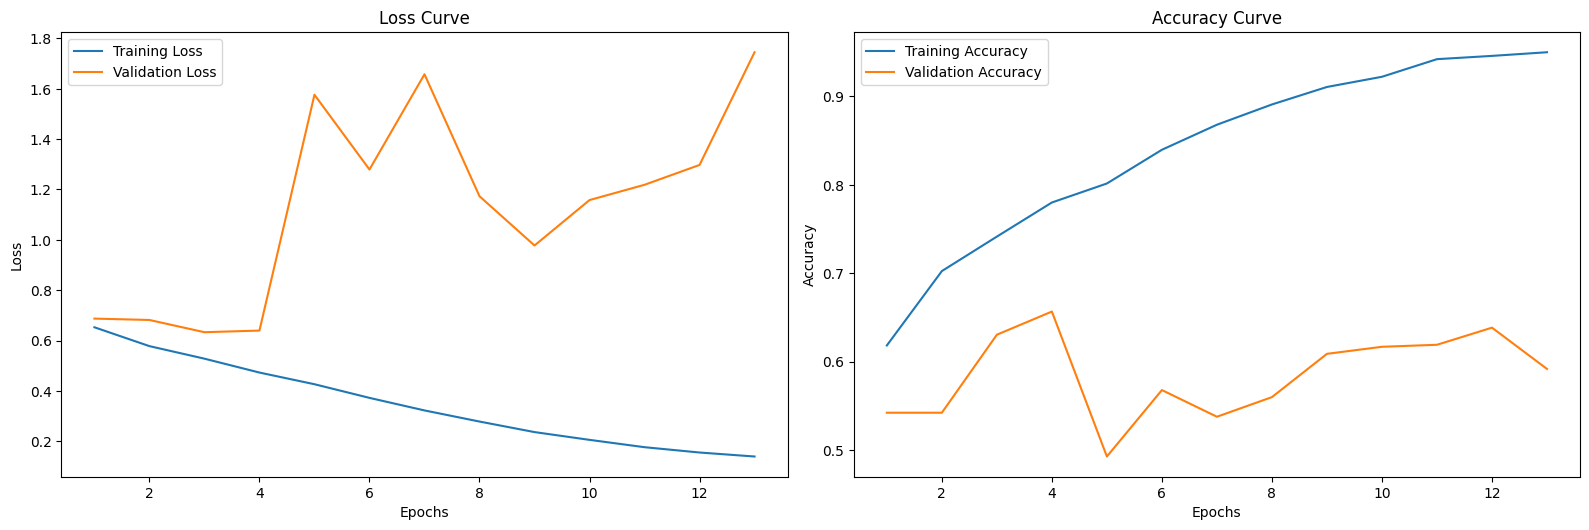

In [157]:
def plot_training_curves(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

<div class="alert alert-info" role="alert">
    
- The validation loss is increasing while the training loss is decreasing
- Gap between training and validation accuracy is increasing as well by epoch
- The model is too simple and has unstable loss curves for validation
- Model is showing signs of overfitting
</div>

In [158]:
def classification_model(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(1024, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(inputs)  # L2 regularization
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.3)(x)  # Increased dropout for regularization
    
    x = layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  
    x = layers.Dropout(0.3)(x)  
    
    x = layers.Dense(256, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  
    x = layers.Dropout(0.3)(x) 
    
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  

    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2 

classification_model = classification_model(input_dim, num_classes=num_classes)
classification_model.summary()

optimizer = Adam(learning_rate=1e-4)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,222,145 (4.66 MB)

 Trainable params: 1,218,305 (4.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

<div class="alert alert-info" role="alert">
    
- To improve the model batch normalization layers were added
- Dropout of 0.3 is also used
- l2 regularization is also added in Dense layers
- These were added in order to control the overfitting of the model
</div>

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5082 - loss: 18.3643 - val_accuracy: 0.5421 - val_loss: 15.1082
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5704 - loss: 14.4888 - val_accuracy: 0.5535 - val_loss: 12.6269
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5959 - loss: 12.2395 - val_accuracy: 0.6469 - val_loss: 10.9451
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5975 - loss: 10.7064 - val_accuracy: 0.6515 - val_loss: 9.6932
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6223 - loss: 9.4925 - val_accuracy: 0.6412 - val_loss: 8.6748
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6240 - loss: 8.4939 - val_accuracy: 0.6560 - val_loss: 7.7957
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6351 - loss: 7.6317 - val_accuracy: 0.6703 - val_loss: 6.9971
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6388 - loss: 6.8764 -

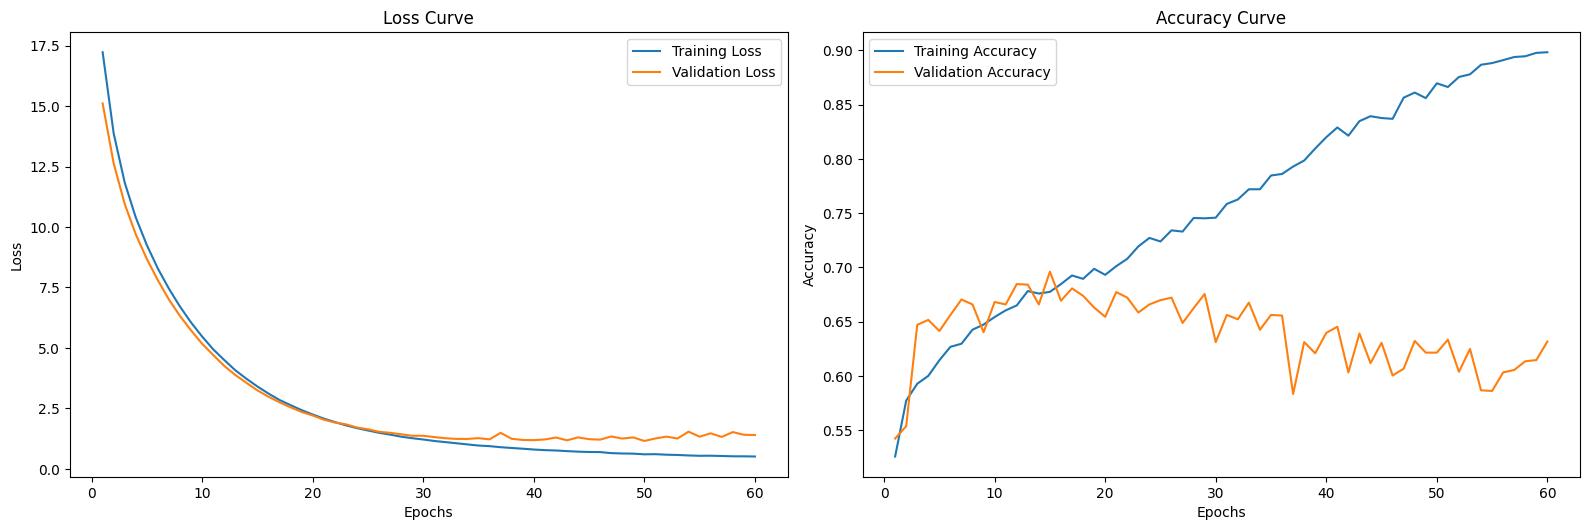

In [159]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

plot_training_curves(history)

<div class="alert alert-info" role="alert">
    
- Loss curves are decreasing at a stable rate
- Gap between training and validation is increasing
- The model is still overfitting
</div>

In [160]:
def build_classification_model_with_residual(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    # residual connection
    x = layers.Dense(1024, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(inputs)  # L2 regularization
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual1 = layers.Dense(1024, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual1 = layers.BatchNormalization()(residual1)  # Batch Normalization
    x = layers.Add()([x, residual1])
    
    # Second block with residual connection
    x = layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x) 
    x = layers.Dropout(0.6)(x)  
    residual2 = layers.Dense(512, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual2 = layers.BatchNormalization()(residual2) 
    x = layers.Add()([x, residual2])
    
    # Third block with residual connection
    x = layers.Dense(256, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x) 
    x = layers.Dropout(0.6)(x)  
    residual3 = layers.Dense(256, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual3 = layers.BatchNormalization()(residual3) 
    x = layers.Add()([x, residual3])
    
    # Fourth block without residuals for bottleneck
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  
    x = layers.Dropout(0.6)(x)  

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = build_classification_model_with_residual(input_dim, num_classes=num_classes)
classification_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_123 (Dense)         │ (None, 1024)           │        525,312 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_101   │ (None, 1024)           │          4,096 │ dense_123[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_64 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_124 (Dense)         │ (None, 1024)           │      1,049,600 │ dropout_64[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, 1024)           │          4,096 │ dense_124[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_57 (Add)              │ (None, 1024)           │              0 │ dropout_64[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_125 (Dense)         │ (None, 512)            │        524,800 │ add_57[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_103   │ (None, 512)            │          2,048 │ dense_125[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_126 (Dense)         │ (None, 512)            │        262,656 │ dropout_65[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_104   │ (None, 512)            │          2,048 │ dense_126[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_58 (Add)              │ (None, 512)            │              0 │ dropout_65[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_127 (Dense)         │ (None, 256)            │        131,328 │ add_58[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_105   │ (None, 256)            │          1,024 │ dense_127[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_66 (Dropout) 

 Total params: 2,607,361 (9.95 MB)

 Trainable params: 2,599,937 (9.92 MB)

 Non-trainable params: 7,424 (29.00 KB)

<div class="alert alert-info" role="alert">
    
- Increased the dropout rate from 0.3 to 0.6
- Implemented skip/residual connections
</div>

In [161]:
optimizer = Adam(learning_rate=1e-3)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5223 - loss: 29.8585 - val_accuracy: 0.5421 - val_loss: 15.6675
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5578 - loss: 12.8863 - val_accuracy: 0.5997 - val_loss: 6.1985
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5939 - loss: 5.0170 - val_accuracy: 0.6412 - val_loss: 2.5524
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6013 - loss: 2.1733 - val_accuracy: 0.6304 - val_loss: 1.3703
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6081 - loss: 1.2469 - val_accuracy: 0.4755 - val_loss: 1.0433
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6329 - loss: 0.9149 - val_accuracy: 0.6071 - val_loss: 0.8458
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6277 - loss: 0.8252 - val_accuracy: 0.5444 - val_loss: 0.9064
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6391 - loss: 0.7887 - val

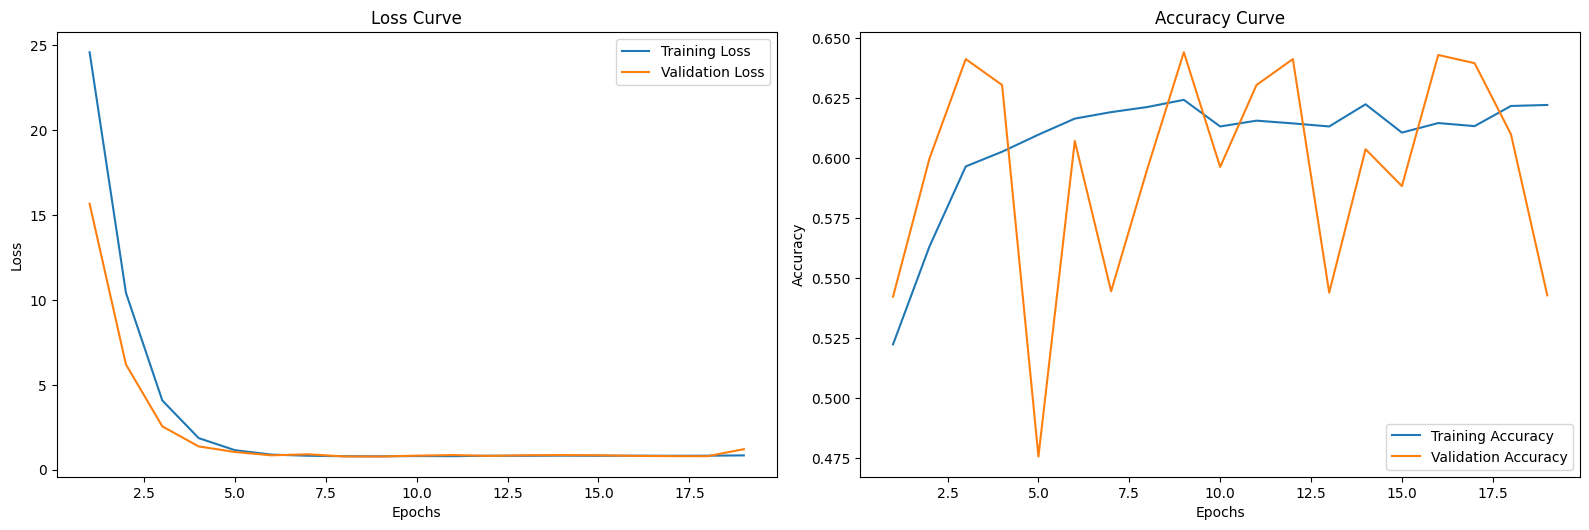

In [162]:
plot_training_curves(history)

<div class="alert alert-info" role="alert">
    
- The loss curves are decreasing steadily
- However, the accuracy curves are now seen to be more erratic for validation.
- Updating the optimizer from Adam to AdamW
- Additionally, will also try to experiment with the learning rate
</div>

In [163]:
input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = build_classification_model_with_residual(input_dim, num_classes=num_classes)
classification_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_131 (Dense)         │ (None, 1024)           │        525,312 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_108   │ (None, 1024)           │          4,096 │ dense_131[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_68 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_132 (Dense)         │ (None, 1024)           │      1,049,600 │ dropout_68[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 1024)           │          4,096 │ dense_132[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_60 (Add)              │ (None, 1024)           │              0 │ dropout_68[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_133 (Dense)         │ (None, 512)            │        524,800 │ add_60[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 512)            │          2,048 │ dense_133[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_69 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_134 (Dense)         │ (None, 512)            │        262,656 │ dropout_69[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 512)            │          2,048 │ dense_134[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_61 (Add)              │ (None, 512)            │              0 │ dropout_69[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_135 (Dense)         │ (None, 256)            │        131,328 │ add_61[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 256)            │          1,024 │ dense_135[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_70 (Dropout) 

 Total params: 2,607,361 (9.95 MB)

 Trainable params: 2,599,937 (9.92 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [164]:
optimizer = AdamW(learning_rate=1e-4)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4963 - loss: 36.1081 - val_accuracy: 0.4579 - val_loss: 31.9801
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5151 - loss: 31.4287 - val_accuracy: 0.4579 - val_loss: 28.8705
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5193 - loss: 28.5053 - val_accuracy: 0.5154 - val_loss: 26.5696
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5352 - loss: 26.3021 - val_accuracy: 0.5683 - val_loss: 24.6770
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5229 - loss: 24.4960 - val_accuracy: 0.5786 - val_loss: 23.0112
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5453 - loss: 22.8346 - val_accuracy: 0.5917 - val_loss: 21.4574
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5383 - loss: 21.2970 - val_accuracy: 0.6099 - val_loss: 20.0061
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5467 - loss: 1

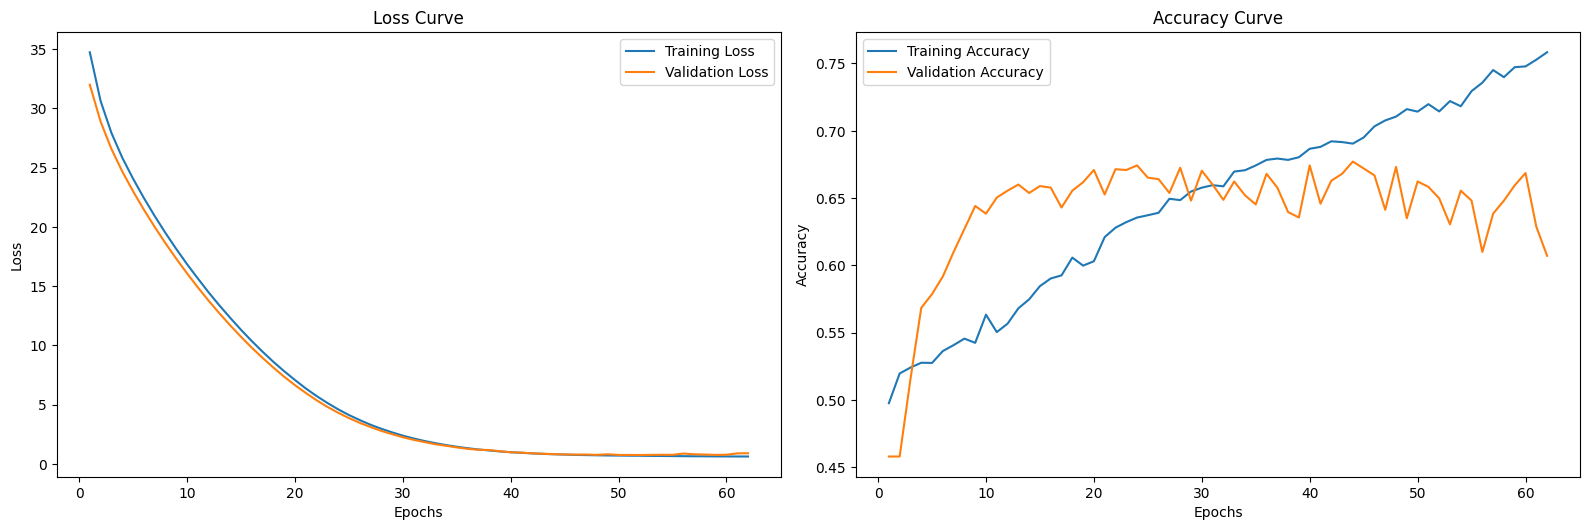

In [165]:
plot_training_curves(history)

<div class="alert alert-info" role="alert">
    
- The loss curves are decreasing at a steady rate
- More importantly the accuracy is increasing at a steady rate for both training and validation
- The gap between the train and validation accuracy is also relatively low
</div>

In [166]:
image_embeds_val1, text_embeds_val1 = get_clip_embeddings_with_adapters(
    val_df['new_image_path'].tolist(),
    val_df['meme_text_masked'].tolist()
)

fused_embeds_val1 = image_embeds_val1 * text_embeds_val1

Processing Batches: 100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


In [167]:
y_val1 = val_df['label']
y_pred1 = classification_model.predict(fused_embeds_val1)
y_pred_labels1 = (y_pred1 > 0.5).astype(int)

pprint(classification_report(y_val1, y_pred_labels1))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.76      0.57      0.65       533\n'
 '           1       0.60      0.79      0.68       443\n'
 '\n'
 '    accuracy                           0.67       976\n'
 '   macro avg       0.68      0.68      0.67       976\n'
 'weighted avg       0.69      0.67      0.66       976\n')


### CLIP feature adapters as trainable layers


<div class="alert alert-info" role="alert">
    
- The clip encoder will still be kept frozen
- The linear projection and feature adapters will be trained (unfrozen)
- Linear projection layers (image_proj_layer and text_proj_layer) are applied to both image and text embeddings to map them into a common embedding_dim.
- Feature adapters (image_adapter and text_adapter) with ReLU activations are then applied to the projected embeddings. These adapters refine the features for both image and text.
- Same architecture and parameters that was discovered in the previous steps of the notebook will be used

The technique is described below: 
- https://arxiv.org/pdf/2409.14703
</div>

In [118]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = TFCLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [119]:
def residual_block(x, units, dropout_rate=0.6, l2_reg=0.01, block_name=""):
    shortcut = x
    
    # Dense layer
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name=f"{block_name}_dense")(x)
    x = layers.BatchNormalization(name=f"{block_name}_batchnorm")(x)
    x = layers.Dropout(dropout_rate, name=f"{block_name}_dropout")(x)
    
    # Project shortcut if dimensions differ
    if shortcut.shape[-1] != units:
        shortcut = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg),
                                name=f"{block_name}_projection")(shortcut)
    
    # Add residual connection
    x = layers.Add(name=f"{block_name}_add")([x, shortcut])
    x = layers.Activation('relu', name=f"{block_name}_activation")(x)
    
    return x

In [128]:
def build_end_to_end_model_with_embeddings(embedding_dim=512, alpha=0.5):
    # Image and Text Embedding inputs
    image_embeds_input = layers.Input(shape=(embedding_dim,), name="image_embeds_input")
    text_embeds_input = layers.Input(shape=(embedding_dim,), dtype=tf.float32, name="text_embeds_input")
    
    # Projection layers (trainable)
    image_proj = layers.Dense(embedding_dim, name="image_projection")(image_embeds_input)
    text_proj = layers.Dense(embedding_dim, name="text_projection")(text_embeds_input)
    
    # Adapter layers (trainable)
    image_adapter = layers.Dense(embedding_dim, activation='relu', name="image_adapter")(image_proj)
    text_adapter = layers.Dense(embedding_dim, activation='relu', name="text_adapter")(text_proj)
    
    # Residual connections for image and text features
    image_features = alpha * image_adapter + (1 - alpha) * image_proj
    text_features = alpha * text_adapter + (1 - alpha) * text_proj
    
    # Feature fusion
    fused_features = layers.Concatenate(name="fused_features")([image_features, text_features])
    
    # Apply residual blocks
    x = residual_block(fused_features, 1024, dropout_rate=0.6, block_name="res_block1")
    x = residual_block(x, 512, dropout_rate=0.6, block_name="res_block2")
    x = residual_block(x, 256, dropout_rate=0.6, block_name="res_block3")
    x = residual_block(x, 128, dropout_rate=0.6, block_name="res_block4")
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name="output")(x)
    
    # Create model
    model = models.Model(inputs=[image_embeds_input, text_embeds_input], outputs=output)
    
    return model

# Initialize the model
end_to_end_model = build_end_to_end_model_with_embeddings()
end_to_end_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_embeds_input        │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_embeds_input         │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_projection (Dense)  │ (None, 512)            │        262,656 │ image_embeds_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_projection (Dense)   │ (None, 512)            │        262,656 │ text_embeds_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_adapter (Dense)     │ (None, 512)            │        262,656 │ image_projection[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_adapter (Dense)      │ (None, 512)            │        262,656 │ text_projection[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_52 (Multiply)    │ (None, 512)            │              0 │ image_adapter[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_53 (Multiply)    │ (None, 512)            │              0 │ image_projection[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_54 (Multiply)    │ (None, 512)            │              0 │ text_adapter[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_55 (Multiply)    │ (None, 512)            │              0 │ text_projection[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_47 (Add)              │ (None, 512)            │              0 │ multiply_52[0][0],     │
│                           │                        │                │ multiply_53[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_48 (Add)              │ (None, 512)            │              0 │ multiply_54[0][0],     │
│                           │                        │                │ multiply_55[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_features            │ (None, 1024)           │              0 │ add_47[0][0],          │
│ (Concatenate)             │                        │                │ add_48[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block1_dense (Dense)  │ (None, 1024)           │      1,049,600 │ fused_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block1_batchnorm      │ (None, 1024)           │          4,096 │ res_block1_dense[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block1_dropout        │ (None, 1024)           │              0 │ res_block1_batchnorm[… │
│ (Dropout)                 │                        │                │                        │
├──────────────────────

 Total params: 3,486,081 (13.30 MB)

 Trainable params: 3,482,241 (13.28 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [129]:
image_embeds_train, image_embeds_val, text_embeds_train, text_embeds_val, labels_train, labels_val = train_test_split(
    image_embeds, text_embeds, labels, test_size=0.2, random_state=42
)

In [130]:
optimizer = AdamW(learning_rate=1e-5) # 1e-5

end_to_end_model = build_end_to_end_model_with_embeddings()
end_to_end_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True 
)


history = end_to_end_model.fit(
    [image_embeds_train, text_embeds_train], labels_train,  
    validation_data=([image_embeds_val, text_embeds_val], labels_val),  
    epochs=100,
    batch_size=32,  # 32
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5021 - loss: 35.1867 - val_accuracy: 0.4510 - val_loss: 34.3436
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5273 - loss: 34.6015 - val_accuracy: 0.4510 - val_loss: 33.9413
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5203 - loss: 34.1928 - val_accuracy: 0.4852 - val_loss: 33.5533
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5135 - loss: 33.7909 - val_accuracy: 0.5108 - val_loss: 33.1719
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5293 - loss: 33.3788 - val_accuracy: 0.5165 - val_loss: 32.7992
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5253 - loss: 33.0094 - val_accuracy: 0.5313 - val_loss: 32.4335
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5320 - loss: 32.6575 - val_accuracy: 0.5245 - val_loss: 32.0754
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5306 - loss: 3

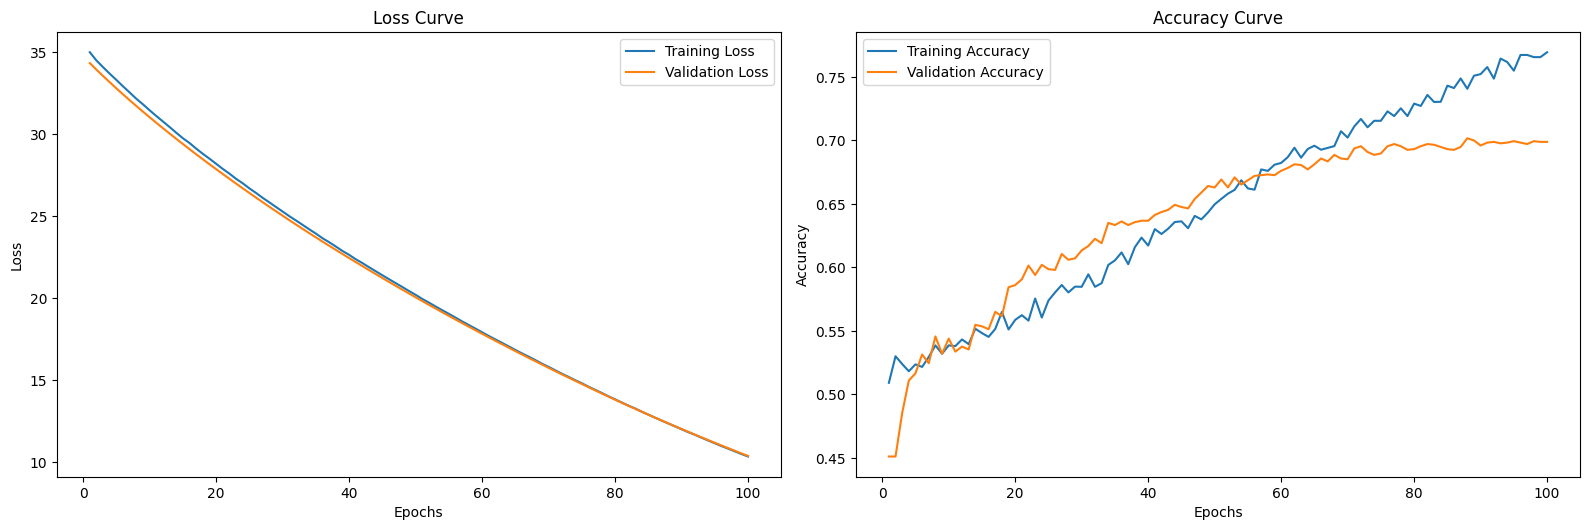

In [131]:
plot_training_curves(history)

<div class="alert alert-info" role="alert">
    
- Noticed that the performance gets better as the learning rate decreases
- Once the learning rate is lower than 1e-6, the performance starts to plateau at 50% accuracy
- At learning rate 1e-5, the different batch sized (16, 32, 64), give the same output
- Increasing the hidden layers only caused the loss to decrease, however the accuracy did not increase/incrased slightly. 
</div>

In [172]:
y_val1 = val_df['label']
y_pred1 = end_to_end_model.predict([image_embeds_val1, text_embeds_val1])
y_pred_labels1 = (y_pred1 > 0.5).astype(int)

pprint(classification_report(y_val1, y_pred_labels1))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.66      0.97      0.78       533\n'
 '           1       0.91      0.40      0.56       443\n'
 '\n'
 '    accuracy                           0.71       976\n'
 '   macro avg       0.79      0.68      0.67       976\n'
 'weighted avg       0.77      0.71      0.68       976\n')


<div class="alert alert-info" role="alert">
To give a model performance summary: 

Since identifying hateful meme content is more important than identifying the non-hateful meme content, the recall metric will be used to determine the best base model. 

Recall for class 1 (hate)

- BERT (frozen) (text classification) - 0.18<br>
- BERT (unfrozen) (text classification) - 0.0<br>
- Resnet50 (frozen) (image classification) - 0.43<br>
- Resnet50 (unfrozen) (image classification) - 0.47<br>
- CLIP  - 0.79<br>
- CLIP (hateclip architecture) - 0.40<br>
</div>

## Model Performance Evaluation

In [132]:
test_df = pd.read_csv('/kaggle/input/testing-memes/val_dataset.csv', index_col=0)
test_df.head()

,id,img,label,text,processed_text,processed_img_path
0,8291,./data/img/08291.png,1,white people is this a shooting range,white people is this a shooting range,./val_images/08291.png
1,46971,./data/img/46971.png,1,bravery at its finest,bravery at its finest,./val_images/46971.png
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...,./val_images/03745.png
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...,./val_images/83745.png
4,80243,./data/img/80243.png,1,mississippi wind chime,mississippi wind chime,./val_images/80243.png


In [133]:
prefix = '/kaggle/input/testing-memes/val_images/'
test_df['processed_img_path'] = test_df['processed_img_path'].str.replace("./", prefix)
test_df.head()

,id,img,label,text,processed_text,processed_img_path
0,8291,./data/img/08291.png,1,white people is this a shooting range,white people is this a shooting range,/kaggle/input/testing-memes/val_images/val_ima...
1,46971,./data/img/46971.png,1,bravery at its finest,bravery at its finest,/kaggle/input/testing-memes/val_images/val_ima...
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...,/kaggle/input/testing-memes/val_images/val_ima...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...,/kaggle/input/testing-memes/val_images/val_ima...
4,80243,./data/img/80243.png,1,mississippi wind chime,mississippi wind chime,/kaggle/input/testing-memes/val_images/val_ima...


In [134]:
labels_test = test_df['label']

In [135]:
image_embeds, text_embeds = get_clip_embeddings_with_adapters(
    test_df['processed_img_path'].tolist(),
    test_df['processed_text'].tolist(),  
    embedding_dim=1024, 
    alpha=0.5
)

test_fused_embeds = image_embeds * text_embeds 
test_fused_embeds

Processing Batches: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it]


array([[ 4.4013625e-05, -2.9738035e-04, -5.2130101e-05, ...,
         4.7580925e-05, -6.4454835e-06, -7.9254198e-05],
       [-2.1225662e-05, -1.1325716e-04,  2.1552653e-06, ...,
        -9.1908209e-04,  3.7536095e-04,  1.4837865e-04],
       [ 7.7196615e-05, -3.1235788e-06,  5.1479412e-05, ...,
         4.2800629e-04, -3.8775761e-04, -5.7773141e-05],
       ...,
       [-2.2327671e-04,  3.1554964e-03, -1.1106404e-03, ...,
        -3.6398804e-05,  8.8602450e-04,  5.3063955e-04],
       [ 3.0767396e-06, -7.2326868e-05,  2.6280139e-04, ...,
        -1.2534013e-03,  1.2564716e-04, -5.7687034e-04],
       [ 2.3110477e-04,  8.0600177e-04, -4.6430045e-04, ...,
        -2.1317895e-03, -6.4803974e-04, -6.1451201e-04]], dtype=float32)

In [116]:
y_pred_prob = classification_model.predict(test_fused_embeds)
y_pred = (y_pred_prob  0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [140]:
# y_pred_prob = classification_model.predict(test_fused_embeds)
# y_pred = (y_pred_prob > 0.5).astype(int)

from pprint import pprint
pprint(classification_report(labels_test, y_pred))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.50      0.96      0.66       250\n'
 '           1       0.47      0.04      0.07       250\n'
 '\n'
 '    accuracy                           0.50       500\n'
 '   macro avg       0.49      0.50      0.36       500\n'
 'weighted avg       0.49      0.50      0.36       500\n')


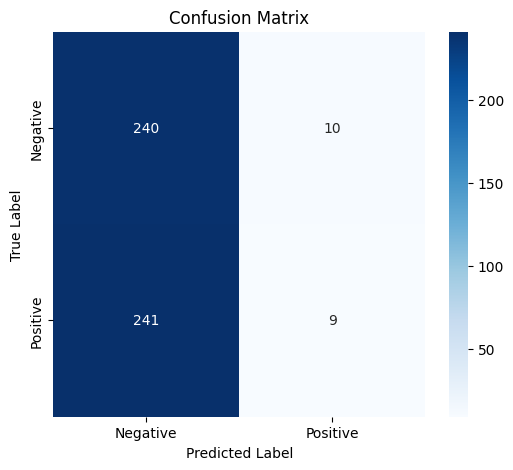

In [141]:
cm = confusion_matrix(labels_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

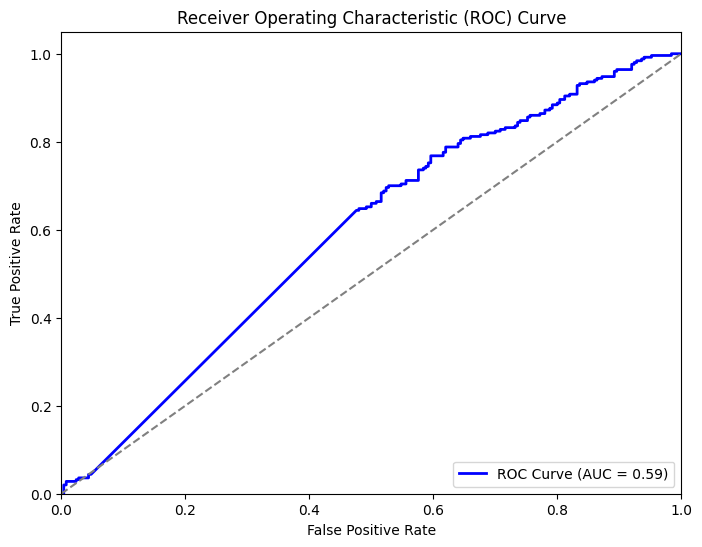

In [142]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(labels_test, y_pred_prob)  # Use probabilities for ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

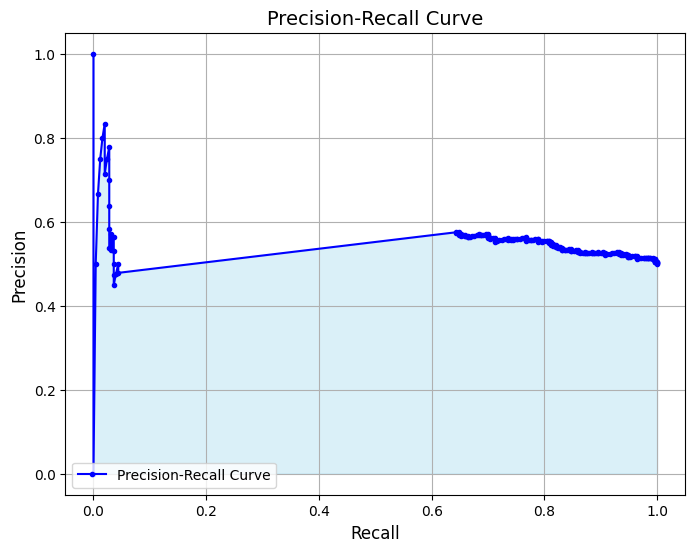

In [143]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds from predicted probabilities
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='b', label='Precision-Recall Curve')
plt.fill_between(recall, precision, color='skyblue', alpha=0.3)
plt.title('Precision-Recall Curve', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


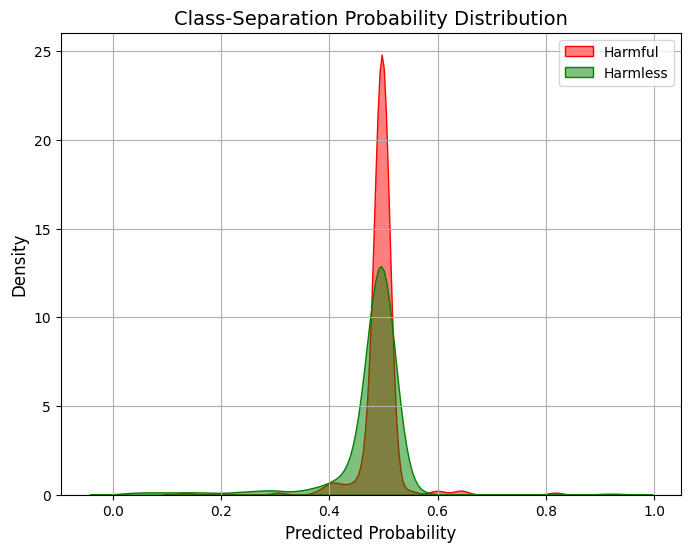

In [144]:
harmful_probs = y_pred_prob[labels_test == 1]  # Harmful memes (label=1)
harmless_probs = y_pred_prob[labels_test == 0]  # Harmless memes (label=0)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(harmful_probs.squeeze(), label='Harmful', fill=True, color='red', alpha=0.5)
sns.kdeplot(harmless_probs.squeeze(), label='Harmless', fill=True, color='green', alpha=0.5)
plt.title('Class-Separation Probability Distribution', fontsize=14)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [145]:
sorted_probs = np.sort(y_pred_prob)[::-1]
sorted_labels = labels_test[np.argsort(y_pred_prob)[::-1]]

# Cumulative gain calculation
cumulative_gains = np.cumsum(sorted_labels) / np.sum(sorted_labels)

# Plotting the Cumulative Gain chart
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 100, len(cumulative_gains)), cumulative_gains * 100, label="Model")
plt.plot([0, 100], [0, 100], linestyle='--', label="Random", color='gray')  # Random guessing line
plt.title('Cumulative Gain Chart', fontsize=14)
plt.xlabel('% of Tested Memes', fontsize=12)
plt.ylabel('% of Harmful Memes Detected', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

ValueError: Cannot index with multidimensional key

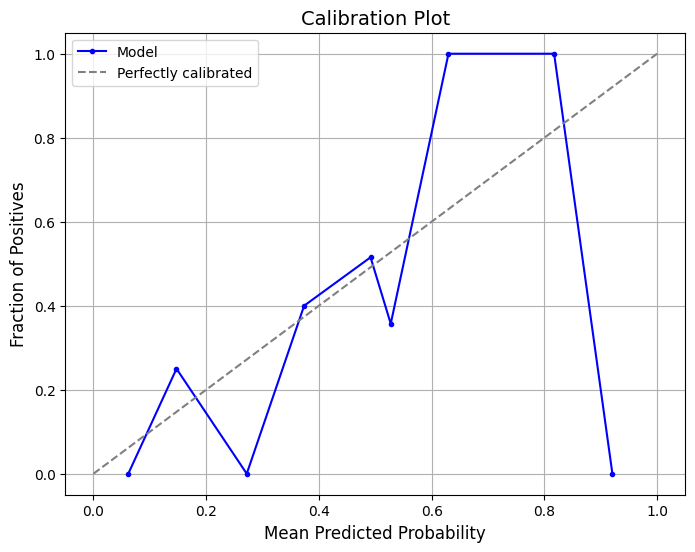

In [146]:
from sklearn.calibration import calibration_curve

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_pred_prob, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='.', color='b', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')  # Ideal line
plt.title('Calibration Plot', fontsize=14)
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Testing against adverserial attacks

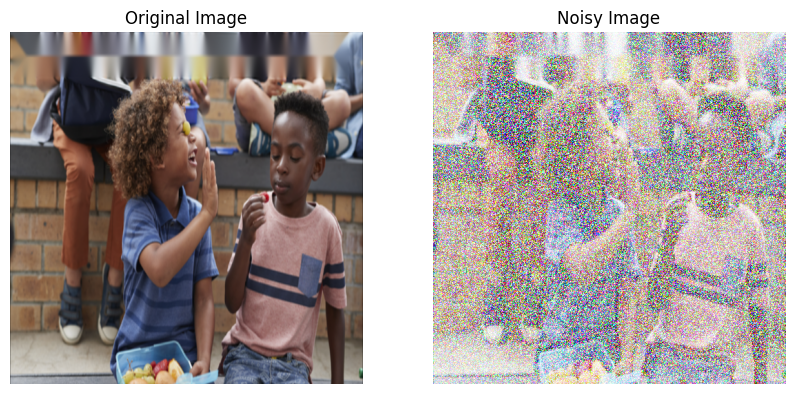

In [122]:
def add_gaussian_noise(image_path, noise_level=10):
    image = cv2.imread(image_path)
    noise = np.random.normal(0, noise_level, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    
    # Convert back to PIL format for compatibility with your pipeline
    return Image.fromarray(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))

# Example: Apply noise to a sample image
sample_image_path = test_df['processed_img_path'].iloc[0]
noisy_image = add_gaussian_noise(sample_image_path)

# Show original and noisy images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open(sample_image_path))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(noisy_image)
ax[1].set_title("Noisy Image")
ax[1].axis("off")

plt.show()

In [126]:
# Run inference on the original and noisy image
original_pred = classification_model.predict(get_clip_embeddings_with_adapters([sample_image_path], ["sample text"])[0])
print(f"Original Prediction: {original_pred}")

noisy_pred = classification_model.predict(get_clip_embeddings_with_adapters([noisy_image], ["sample text"])[0])
print(f"Noisy Image Prediction: {noisy_pred}")

Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Original Prediction: [[1.]]


Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Noisy Image Prediction: [[1.]]


# Exporting Best Model

In [19]:
# classification_model.save('classification_model.h5') 

converter = tf.lite.TFLiteConverter.from_keras_model(classification_model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


Saved artifact at '/tmp/tmpgxpalmmu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140283672841904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140289157982944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680365856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680358464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680362336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680360400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680373424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680370256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283672667312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140285858787952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140284036858800: Tens

W0000 00:00:1737432219.200128    1680 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737432219.200152    1680 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 04:03:39.200979: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.203100: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 04:03:39.203122: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpgxpalmmu
I0000 00:00:1737432219.223305    1680 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-21 04:03:39.228662: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 04:03:39.403179: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.445861: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [20]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='best_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
